# Sideband analysis on a jammed channel
This code aims to do some analysis on the sidebands of the channel previouvsly studied with Deep Learning tools.
\
One problem noticed in the anomaly classificator was the fact that the so called *watchdog* is not able to determine there difference between jammed channel and a channel with no i/q coordinates (that could have for example problems in recieving data).
\
The proposed idea aims to study the behaviour of the power among the sidebans of the signal, in order to see if there is a correlation between the power among the sidebands of the channel and the presence of a jammer.
\
\
Two parameters will be computed: the first one will be the power over the sidebands in a waterfall plot window composed by *n* PSDs; the second one will be the mean ratio between the power in the sidebands and the total power among the same waterfall plot.
\
Then, there will be computed *p* waterfall plots and from that there will be extracted the mean and the standard deviations of the parameters explained above.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

[False False False ... False False False]
Total power: 7.908356926155827e-09
Mainband_power. 6.482805485181867e-09
Ratio: 18.02588646775843 %


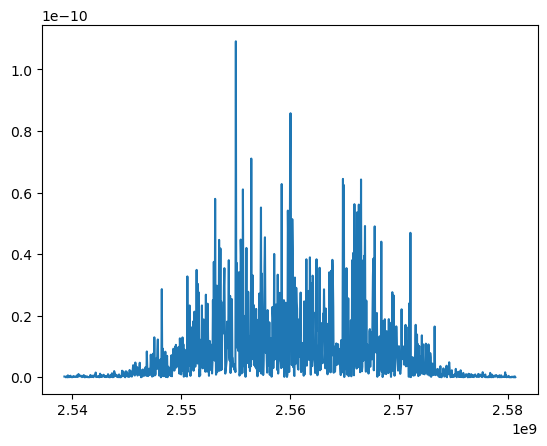

In [2]:
## example of how to compute a PSD and plot it
file = np.fromfile(open("empty_channel"), dtype=np.complex64) ## empty channel case
samp_rate=41.44*1e6
##f is my array that contains i/q samples
n=1024
x=file[0:0+n] ##first n samples
PSD = np.abs(np.fft.fft(x))**2 / (n*samp_rate)
PSD_shifted = np.fft.fftshift(PSD)
fc=2.56*1e9
f = np.arange(samp_rate/-2.0, samp_rate/2.0, samp_rate/n) # start, stop, step.  centered around 0 Hz
f += fc ## shift the plot
bandwidth=18.43*1e6
mask_1= f>=(fc-bandwidth/2)
mask_2= f<=(fc+bandwidth/2)
mask=np.bitwise_and(mask_1,mask_2) ## mask of my mainband
print(mask)
total_power=np.sum(PSD_shifted)
mainband_power=np.sum(PSD_shifted[mask])
sideband_power= total_power- mainband_power ## compute the power among mainband, sideband and the total power
ratio= sideband_power*100/ total_power
print("Total power:", total_power)
print("Mainband_power.", mainband_power)
print("Ratio:", ratio, "%")
plt.plot(f, PSD_shifted)
plt.show()


##JUST TO SEE IF I AM PLOTTING EVERYTHING CORRECTLY!!!!!



In [3]:
def compute_sideband(channel_descriptor):
    ch_desc = np.fromfile(open(channel_descriptor), dtype=np.complex64)
    waterfall_window=100 ##  number of PSDs for each waterfall plot
    sideband_power_values=[] ## values of the power of the sideband for each waterfall plot
    ratio_values=[] ## values of the power of the sideband for each waterfall plot
    samp_rate=41.44*1e6
    bandwidth=18.43*1e6 ## known by priori parameter
    n=1024 ## size of my fft
    num_waterfall=200## number of waterfall plots that i want to generate
    lo_idx=0 ## lower index to iterate in my file descriptor
    for i in range(num_waterfall):
        sideband_power_waterfall_window=0 ## reset the values 
        ratio_waterfall_window=0
        for j in range(waterfall_window):
            x=ch_desc[lo_idx:lo_idx+n]
            PSD = np.abs(np.fft.fft(x))**2 / (n*samp_rate) ## compute PSD and normalize it by n*samp_rate
            PSD_shifted = np.fft.fftshift(PSD) ## shift psd 
            fc=2.56*1e9 ##2.56 Ghz, carrier frequency
            f = np.arange(samp_rate/-2.0, samp_rate/2.0, samp_rate/n) # start, stop, step.  centered around 0 Hz, bandwidth is the samp rate
            f += fc ## shift the plot
            mask_1= f>=(fc-bandwidth/2)
            mask_2= f<=(fc+bandwidth/2)
            mask=np.bitwise_and(mask_1,mask_2) ## i filter the frequencies in my mainband
            total_power=np.sum(PSD_shifted) ## compute the total power over the PSD
            mainband_power=np.sum(PSD_shifted[mask]) ## compute the mainband power using our mask
            sideband_power= total_power- mainband_power
            ratio= sideband_power*100/ total_power
            sideband_power_waterfall_window=sideband_power_waterfall_window+ sideband_power
            ratio_waterfall_window=ratio_waterfall_window+ratio
            lo_idx=lo_idx+n
        sideband_power_values.append(sideband_power_waterfall_window) ## i append the values of the sideband of a waterfall plot
        ratio_values.append(ratio_waterfall_window/waterfall_window) ## mean values of the ratios among a waterfall plot
        
    return sideband_power_values, ratio_values
    
    

In [4]:
val_empty=compute_sideband("empty_channel")
sideband_power_list=val_empty[0]
ratio_values_list=val_empty[1]
print(len(sideband_power_list)) ## check to see if everything is ok
print(len(ratio_values_list))

200
200


In [5]:
def compute_cdf(values):
    my_range=np.arange(min(values),max(values),(max(values)-min(values))/200) ## my range goes from the minimum of the list to the max, i chose 200 steps
    cdf_list=[] ## list of cdf
    for elem in my_range: ## for each element in my range
        cdf=0
        for val in values:
            if(elem>=val):
                cdf=cdf+1
        cdf_list.append(cdf/len(values)) ## append cdf of that value
    return my_range, cdf_list

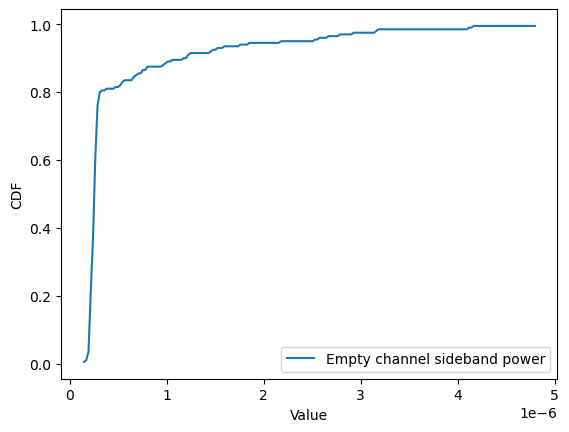

In [6]:
my_values=compute_cdf(sideband_power_list)
axis_x=my_values[0]
axis_y=my_values[1]
plt.plot(axis_x,axis_y, label="Empty channel sideband power")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.show()

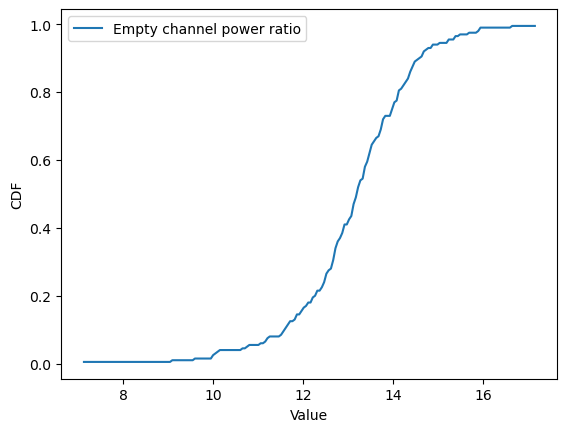

In [7]:
my_values=compute_cdf(ratio_values_list)
axis_x=my_values[0]
axis_y=my_values[1]
plt.plot(axis_x,axis_y, label="Empty channel power ratio")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.show()

In [8]:
val_tx=compute_sideband("tx_channel")
sideband_power_list=val_tx[0]
ratio_values_list=val_tx[1]


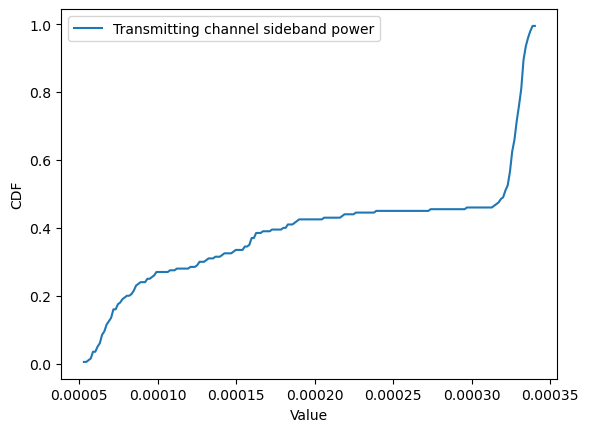

In [9]:
my_values=compute_cdf(sideband_power_list)
axis_x=my_values[0]
axis_y=my_values[1]
plt.plot(axis_x,axis_y, label="Transmitting channel sideband power")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.show()

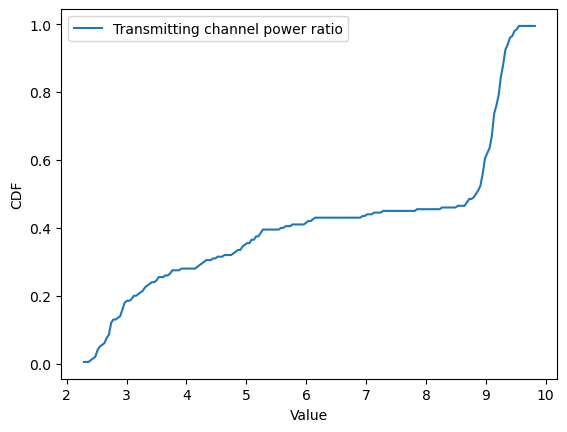

In [10]:
my_values=compute_cdf(ratio_values_list)
axis_x=my_values[0]
axis_y=my_values[1]
plt.plot(axis_x,axis_y, label="Transmitting channel power ratio")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.show()

In [14]:
val_tx=compute_sideband("jammed_channel") ## uniform jammed channel
sideband_power_list=val_tx[0]
ratio_values_list=val_tx[1]

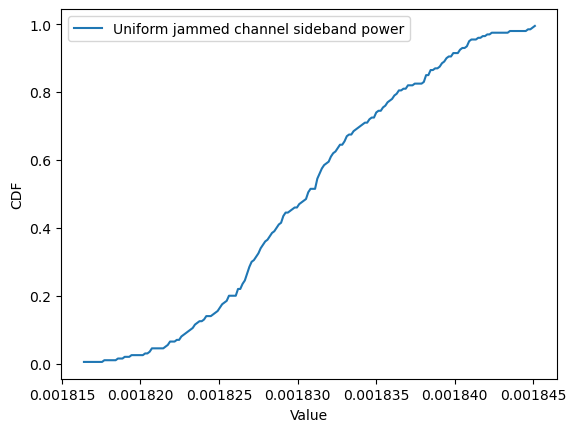

In [15]:
my_values=compute_cdf(sideband_power_list)
axis_x=my_values[0]
axis_y=my_values[1]
plt.plot(axis_x,axis_y, label="Uniform jammed channel sideband power")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.show()

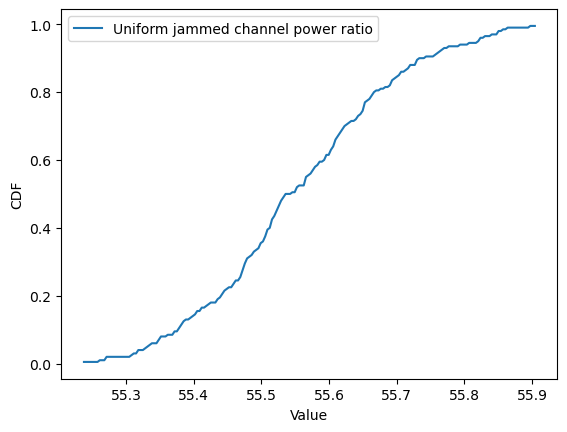

In [16]:
my_values=compute_cdf(ratio_values_list)
axis_x=my_values[0]
axis_y=my_values[1]
plt.plot(axis_x,axis_y, label="Uniform jammed channel power ratio")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.show()

In [17]:
val_tx=compute_sideband("jammed_channel_gaussian") ## gaussian jammed channel
sideband_power_list=val_tx[0]
ratio_values_list=val_tx[1]

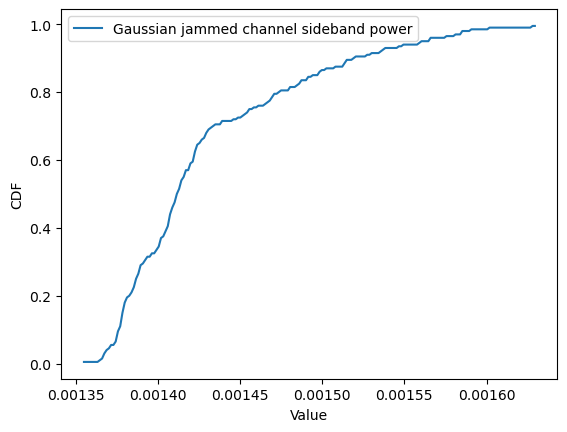

In [18]:
my_values=compute_cdf(sideband_power_list)
axis_x=my_values[0]
axis_y=my_values[1]
plt.plot(axis_x,axis_y, label="Gaussian jammed channel sideband power")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.show()

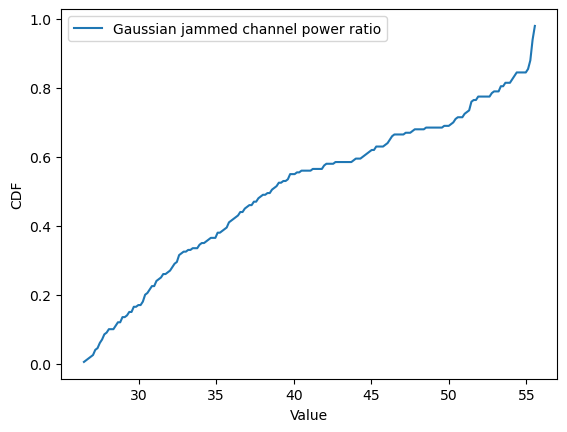

In [19]:
my_values=compute_cdf(ratio_values_list)
axis_x=my_values[0]
axis_y=my_values[1]
plt.plot(axis_x,axis_y, label="Gaussian jammed channel power ratio")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.show()

<strong> Comments on the result </strong></p>
As we can see from the results shown above, in the first two cases (the "normal cases"), the power among the sideband is very low, while in the jammed channel case is not neglibigle, especially if we see the mean of the ratios computed: in fact, in the first two cases the ratios rarely exceed the 15%, while in the jammed case we have a mean ratio of 55%.
\
A proposed approach will be to set a treshold based on these parameters, and add this feature to our classifier to make him determine if the detected anomaly will be a jammed channel or not.


